# Designer Similarity
In this section, we aim to find the similarity among designers. This similarity will be used to build the recommender engine. We apply K-mean to the subcategory of product sold by designer. 

## Description of data set

The data was colleced from Pinkoi website. The date of collection is 12/15

## Field
* Product Category: the subcategory the products belong to, string
* Product Tag: tags designer use to descibe his/her product, string
* desing house: the store of the designer, string

## Data Pre-Processing
We simply filter out the missing values

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_raw=pd.read_csv("input/designer_data.csv",sep=",",encoding='utf8')

In [6]:
data_clean=data_raw[data_raw['Product Catgory']!='Missing']

In [7]:
data_clean=data_clean.reset_index(drop=True)

In [8]:
data_clean.head()

,Product Catgory,Product tag,design house
0,"肩背包/斜背包 (2),零錢包 (1),筆盒/筆袋 (1),杯墊 (1),家飾/擺飾 (1)","\n ,handmade, (6),側背袋, ...",siusiukappaegg
1,手提包 (2),"\n ,dearbnb, (2),tiffan...",dearbnb
2,"卡片/明信片 (1),筆插/筆筒/筆套 (1),陶器/陶飾 (4),淺碟/盤子/餐盤 (4)...","\n ,card, (1),christmas...",delightful-time
3,"T 恤 (女) (1),背心 (女) (8),連帽外套/T 恤 (中性) (4),背心 (男...","\n ,手作, (49),手工, (49),手...",yenyen
4,"肩背包/斜背包 (8),手提包 (2),束口後背包 (1),卡片/明信片 (3),貼紙 (2...","\n ,handmade, (36),動物, ...",patchworkshop


In [72]:
len(data_clean)

5194

The valid number of designer is 5194

## Designer Clustering
This part aims to find the most similar designer to one designer. To find this designer, I propose two steps similarity calculations to solve this problem. The first step is course similarity calculation by applying Kmean algorithm in SparkMllib. The second step is fine similarity calculation by computing cosine similarity of product tag owned by designer within the cluster designer belong to. For the features used in two steps and why I separation of calculation into two steps, please see the next section


### Feature Selection

Based on data available, we use subcategory of product sold by a designer as input feature of first step kmean. One may ask why not combine the product tag together to form the input feature and run one-step calculation. followings are my consideration:

#### Memory issue
According to API in SparkMLlib, the input data of kmean is array-like data, wichh means we have to convert each prodcut tag owned by designer to vector space of ~30000. Even though we apply TF-IDF to filtered out the less characteristic product tags, the size of vector space is of ~20000. It's unefficient to store such large and sparse vector. However, my proposed approach only have to consider subcategory, whcih is only 173.

#### Update issue
Though the combination of product tag and subcategory might imporve the clustering result, the product tag is too unstable (several products tags will disappear or appear in one day for a designer). To get bettter recommendation, we must update it frequently. However, to compute such large vector is time-consuming. It might not be worthwile to sacrify computing resource to few improvement of clustering result. Instead of using unstable product tag, the subcategory is more stable since the coverage of subcategory is larger. Hence, it need less update. Though it might be less accurate, it's a trade-off of my design, please see Coverage issue

#### Scalability issue
Concering the previous two points, when number of designer become larger and larger(Pinkoi growth rapidly, right?). Such combination is both memory and time consuming. It is not scalable. Nonetheless, my approach is more scalable due to far smaller size of feature space. 

#### Coverage issue
This issue is related to design of my prototype of recommender engine. The position of designer recommender aims to increase the coverage and bring more serendipity/novelty product to user(see details in slide X). So the role of preciseness is not that important.

<br>
In conclusion, the intergation of product tag will cause a large and sparse array, which is unfavored of our system design. Though I have some fast computing method to address such sparse array that can beat numpy(See customer data generation), it requies to modify the source code of Spark K-mean which might lose the speedup of using spark. 

## First step similarity calculation: K-mean

In following section, we apply K-means in Spark MLlib to cluster the designer. Be sure to have the envrionemnt for running Spark1.4 or up if you want to implement the code.

There is no theoretical method to determine the parameter of K-means(i.e number of cluster k, iteration...etc). A generally accepted method is called <a href='https://www.quora.com/How-can-we-choose-a-good-K-for-K-means-clustering'>elbow method</a>. It says that the number of cluster can be determined by plotting clustering error versus the number of cluster k. The value k is the number of cluster that cause the large decrease of error. Elbow method is a rule of thumb, the exact number of k should be determined by real application and scenario. I choose K=11 as the number of cluster. For the process of finding k by applying elbow method, please refer to Appendix2

#### Parsing
The following two helper function is used to parse the number in the subcategory.(i,e 肩背包/斜背包 (2)). I just add some comment and not going to dig into how to parse it 

In [3]:
#This function is used to parse and return the a list of all subcategories
def Parse_cat(s):
    tmp=s.split(",")
    L=[]
    # The tricky point here the each category string contains difference " ". Following parse scehme is based on our observation
    for g in tmp:
        #normal case, ['category (number)']
        if len(g.split(" "))==2:
            L.append(g.split(" ")[0])
        #One white space case ['category ' '(number)' ]
        elif len(g.split(" "))==3:
            g_tmp=g.split(" ")
            L.append("".join(g_tmp[0:2]))
        #two white space case['category '  '(nuber)']
        else:
            g_tmp=g.split(" ")
            L.append("".join(g_tmp[0:3]))
    return L

In [4]:
#This function is used to convert the following:
# 肩背包/斜背包 (2),零錢包 (1),筆盒/筆袋 (1),杯墊 (1),家飾/擺飾 (1) ->[0,0..1,0,1..,0]
def Feature_xtra_cat(dh):
    
    L=[]
    tmp_1=dh.split(",")
    #The same tricky issues as mentined in parse cat
    for g in tmp_1:
        if len(g.split(" "))==2:
            L.append(g.split(" ")[0])
            L.append(g.split(" ")[1])

        elif len(g.split(" "))==3:
            g_tmp=g.split(" ")
            L.append("".join(g_tmp[0:2]))
            L.append(g_tmp[2])
        else:
            g_tmp=g.split(" ")
            L.append("".join(g_tmp[0:3]))
            L.append(g_tmp[3])
    f_array=np.zeros(len(Product_catgory))
    for f in L:
        if L.index(f)%2==0:
            f_array[Product_catgory.index(f)]=int(L[L.index(f)+1][1:-1])
           
    return f_array

In [9]:
pc_tmp=[Parse_cat(e) for e in data_clean['Product Catgory']]

In [10]:
Product_catgory=[]
for i in pc_tmp:
    Product_catgory.extend(i)
Product_catgory=list(set(Product_catgory))


Following step transforms the data:<br>
<br>
designer A C1(10), C2(5),C3(1) to desingerA [0,0.0,0,10,0..0,5,0,0,..1,0..0]
<br>
<br>
Each designer has a feature vector which has length equals to the number of subcategory

In [77]:
Feature_cat=[Feature_xtra_cat(e) for e in data_clean['Product Catgory']]

In [78]:
len(Feature_cat)

5194

In [82]:
#Store feature of each designer to dataframe
Feature_df=pd.DataFrame(columns=Product_catgory,index=range(len(data_clean)))
user_id=[]
for i in xrange(len(Feature_cat)):
    user_id.append(u'{s}'.format(s=i))

for i in xrange(len(data_clean)):
    Feature_df.iloc[i]=Feature_cat[i]

Feature_df.insert(0,u'UID',user_id)
Feature_df.to_csv('Intermediate/designer_catfeature.csv',sep=",",encoding='utf8',index=False,header=None)

In [125]:
Feature_data=sc.textFile('Intermediate/designer_catfeature.csv')

In [85]:
parse_data=Feature_data.map(lambda x:(x.split(",")[0],x.split(",")[1:]))\
.map(lambda x:(x[0],np.array([float(e) for e in x[1]])))

In [87]:
parse_data_final=parse_data.map(lambda x:x[1])

We define two helper functions: CalGroupInfo and TellGroupInfo. The first function calculate the feature represented by the group and the second one tell will print out these feature

In [88]:
def CalGroupInfo(g,K):
    G_num=[]
    G_feature=[]
    G_designer=[]
    for k in range(K):
        #print "Group k: "+str(k)
        G_num.append(g.filter(lambda g0:g0[2]==k).count())
        G_feature.append(g.filter(lambda g0:g0[2]==k).map(lambda x:(1,x[1])).reduceByKey(lambda x,y:x+y).collect())
        G_designer.append(g.filter(lambda g0:g0[2]==k).map(lambda x:(x[0])).collect())
    
    
    return G_num,G_feature,G_designer

In [89]:
def TellGroupInfo(gn,gf,gd):
    for i in xrange(len(gn)):
        print "Group {s}".format(s=i)+" num="+str(gn[i])
        print "Desinger in {s} group:".format(s=i)
        #print gd[i], len(gd[i])
        
        #tmp=sorted(gf[i][0][1])
        SF=np.percentile(gf[i][0][1],95)
        
        dominant_f=[e if e>=SF else 0.0 for e in gf[i][0][1]]
        #tmp_d=setsorted(dominant_f, reverse=True)
        for f in set(dominant_f):
            if f!=0:
                print Product_catgory[list(gf[i][0][1]).index(f)]     

This error function is used to calculate the distance for a point to cluster it belongs to

In [90]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return np.sqrt(sum([x**2 for x in (point - center)]))

In [92]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters_k11 = KMeansModel.load(sc, "Intermediate/model_designer")
prediction_k11=parse_data.map(lambda p:(p[0],p[1],clusters_k11.predict(p[1])))

Group_num11,Group_feature11,Group_desinger11=CalGroupInfo(prediction_k11,11)
pd.Series(Group_num11).to_csv("Intermediate/group_num.csv",sep=",",encoding='utf8',index=False)
Group_num11

[14, 4, 4, 74, 4725, 187, 49, 7, 58, 60, 12]

In [93]:
TellGroupInfo(Group_num11,Group_feature11,Group_desinger11)

Group 0 num=14
Desinger in 0 group:
iPhone週邊
其他
Android週邊
肩背包/斜背包
平板/電腦保護套
電腦包
抱枕
時鐘/鬧鐘
充電器/傳輸線
Group 1 num=4
Desinger in 1 group:
其他
媽媽包
啟發玩具
童鞋
童裝
彌月收涎
圍兜/領巾/配件
Group 2 num=4
Desinger in 2 group:
杯墊
圍兜/領巾/配件
髮飾
耳環
捲線器/電線收納
徽章/別針
鑰匙圈/鑰匙包
卡片/明信片
胸針
Group 3 num=74
Desinger in 3 group:
皮夾/錢包
束口後背包
後背包
零錢包
手提包
其他
帽子
肩背包/斜背包
化妝包/雜物包
Group 4 num=4725
Desinger in 4 group:
項鍊/墜子
鑰匙圈/鑰匙包
手鍊/手環
耳環
其他
肩背包/斜背包
零錢包
家飾/擺飾
卡片/明信片
Group 5 num=187
Desinger in 5 group:
胸針
項鍊/墜子
髮飾
鑰匙圈/鑰匙包
耳環
手鍊/手環
其他
手錶
戒指
Group 6 num=49
Desinger in 6 group:
外套/大衣(女)
項鍊/墜子
裙子
針織衫/毛衣(女)
襯衫(女)
洋裝
褲子/下身(女)
上衣(女)
T恤(女)
Group 7 num=7
Desinger in 7 group:
串珠材料
手鍊/手環
胸針
戒指
項鍊/墜子
耳機/耳機週邊
鑰匙圈/鑰匙包
耳環
髮飾
Group 8 num=58
Desinger in 8 group:
貼紙
筆記本/手帳
化妝包/雜物包
卡片/明信片
其他
杯墊
紙膠帶
票夾/隨身夾
包裝材料
Group 9 num=60
Desinger in 9 group:
杯墊
鑰匙圈/鑰匙包
Android週邊
票夾/隨身夾
咖啡杯/馬克杯
其他
iPhone週邊
零錢包
手錶
Group 10 num=12
Desinger in 10 group:
iPhone週邊
手提包
上衣(女)
T恤(女)
上衣/T恤(男)
帽子
束口後背包
童裝
手鍊/手環


Note that we have a group has really large number(4725). To be honest, I can't figure out why. I have tried different k(27,19,15..), a group with very large number still exist

## Second step similarity calculation: Cosine similarity within group
In this step, we will find the most similar designer of each designer by calculating the cosine similarity of product tag. The first thing we have to do is to filtered out the unrepresentative tags by TF-IDF<br>
<br>
the idea of TF-IDF, which is quite common in information retrival. We treat each designer is a document and the product tags are some key words to descirbe this designer. The idea beind TF-IDF is that the more frequent a word appear, the more important it is for classification of document. However, if this word appear in almost evey document, then it is too general and have no important meaning (just think about be-verb in English). With some normalization, the calculation of TF-IDF score of i-th key word can be written as:

* Term Frequency($TF_{i}$)=numbe of times of key word i appear in all document
* Inverse Document Frequency(IDF$_{i}$)=number of document key word i appear
* N: total number of document
* max(f,i)= maximum key word frequency
$$ TF-IDF_{i}=TF_{i}/max(f,i)*log(N/IDF_{i})$$




In [ ]:
# the parameter elewise is used to check whether this function is used to return a list of whole tag or return a dictionary of tag for each 
#designer
def parse_tag(s,elewise):
    if elewise==False:
        tmp=s.split(",")[1:-1]
        return [g for g in tmp if tmp.index(g)%2==0]
    else:
        tmp=s.split(",")[1:-1]
        #The tricky points here is that some data is organized as 'subtag' 'number' while some are inverse!
        if tmp[0][0]!=' ':
            key=[g for g in tmp if tmp.index(g)%2==0]
            value=[float(g[2:-1]) for g in tmp if tmp.index(g)%2!=0]
            dic={}
    
            for e in zip(key,value):
                dic[e[0]]=e[1]
        else:
            key=[g for g in tmp if tmp.index(g)%2!=0]
            value=[float(g[2:-1]) for g in tmp if tmp.index(g)%2==0]
            dic={}
    
            for e in zip(key,value):
                dic[e[0]]=e[1]
            
            
        return dic

In [ ]:
pct_tmp=[parse_tag(e,False) for e in data_clean['Product tag']]
Product_tag=[]
for i in pct_tmp:
    Product_tag.extend(i)

Product_tag=list(set(Product_tag))

In [ ]:
def TF_IDF_tag(d_list):
    tf_list=[]
    idf_list=[]
    for t in Product_tag:
        #print t
     
        idf=0
        tf=0
        for d in d_list:
            if t in d.keys():
                tf+=d[t]
                idf+=1.0
            else:
                continue
        #print tf
        #print idf
        tf_list.append(tf)
        idf_list.append(idf)
        #print tf_list
        #print idf_list
    TF_IDF=[((e[0]/max(tf_list)))/np.log10(e[1]/len(d_list)) if e[0]!=0 else -1000 for e in zip(tf_list,idf_list) ]
    Dominant_f=[(e[0],e[1]) for e in zip(Product_tag,TF_IDF) if (e[1]<np.percentile(TF_IDF,71)) and (e[1]!=1000)]
    #return TF_IDF,max(tf_list)
    return Dominant_f,TF_IDF

In [104]:
Product_tag_dic=[parse_tag(e,True) for e in data_clean['Product tag']]
Dominant_f,Tf_Idf_score=TF_IDF_tag(Product_tag_dic)
np.percentile(Tf_Idf_score,71)

-4.7398453644956682e-06

Based on obervation, score above 71 percentile=-4.7398e-06. This score happened when the tag appear only once in only onw design house, which is too rare. We eliminate all tags with this score

In [ ]:
len(Product_tag)

In [ ]:
len(Dominant_f)

In [114]:
D=[]
V=[]
for i in Dominant_f:
    D.append(i[0])
    V.append(i[1])
Feature_D=set(D)

df_d=pd.DataFrame(data=V,index=D)
df_d.to_csv("Intermediate/feature_d.csv",encoding='utf8',index=False)

We reduce the orginal features space  by around 10000! The feature space is still large but it is better now. Can we do better? Sure! We can apply gensim to find the word with similar sematics and eliminate the similar ones. I just stop here and for some reasons(see dicussion)

To caculate the similarity, I define two function BuildSim and DeSimCal. The first one is repsonsible for looping the user in the same group and DeSimCal is used to calculate the similarity among them. I don't go into the detail of implementation because it just parsing and computing

In [140]:
# Calculation of similarity scores among designer
def DeSimCal(t,f):
    Sim=[]
    #print t
    for s in f:
        if s==t:
            continue
        else:
            #print w[g_ele][f.index(s)]
            #print s
            common=set(s.keys()).intersection(set(t.keys()))
            dot=0.0
            for c in common:
                dot+=s[c]*t[c]
            n1=np.sqrt(sum([x*x for x in s.values()]))
            n2=np.sqrt(sum([x*x for x in t.values()]))

            Sim.append(dot/(n1*n2))
            #print Sim
    return f[Sim.index(max(Sim))]   

In [144]:
#THis function aims to find the top 1 similar designger of each designer
def BuildSim(w,sim_num,k):
    col=['Group','Designer']
    n=[str(e) for e in range(sim_num)]
    col.extend(n)
    Sim_Designer=pd.DataFrame(columns=col,index=range(len(data_clean)))
    # g_ele: group number, g_ele=0 means 0 group. 
    for g_ele in xrange(k): # from group 0 to group X . X=11 here
        #This function parse the product tag and convert it to dictionary. 
        #The key of dicionary is produc tag represented by the index in Feature_D
        #The value of key is the number of this prodcut tag
        F_i=[parse_tag(data_clean.ix[int(e),'Product tag'],True) for e in w[g_ele]]
        
        #This list is
        F_i_red=[]
        for e_dic in F_i:
            dic={}
            #print e.keys()
            comm=set(e_dic.keys()).intersection(Feature_D)
            #print comm
            for k in comm:
                dic[list(Feature_D).index(k)]=e_dic[k]
            F_i_red.append(dic)
        Sim_list=[]
        for de in xrange(len(F_i_red)):
            target=F_i_red[de]
            #print target.keys()
            MostSim=DeSimCal(target,F_i_red)
        
            tmp=[]
            tmp.append(g_ele)
            tmp.append(w[g_ele][de])
            tmp.append(w[g_ele][F_i_red.index(MostSim)])
            Sim_Designer.ix[int(w[g_ele][de]),:]=tmp
    return Sim_Designer
        #return F_i_red
        #for g in xrange(len(Group_desinger11[i])):
        #    Similarity_Designer.ix[g,'Group']=i
        #    Similarity_Designer.ix[g,'Designer']=Group_desinger11[i][g]

In [145]:
Similarity_Designer=BuildSim(Group_desinger11,1,11)

In [178]:
Similarity_Designer.head()

,Group,Designer,0
0,4,0,955
1,4,1,2474
2,4,2,1026
3,4,3,4958
4,4,4,3681


If we look up the similarity of group 4, we might find that some of the most similar designer we calculated is unsimilar as we expect while the others group is ok. Let's keep going as I think the purpose of the designer engine is to increase the coverage of recommendation system. So the unsimilar product could be tolerate 

In [147]:
Similarity_Designer.to_csv("Intermediate/design_sim.csv",sep=",",encoding='utf8')

## Appendix: Finding K

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel
error_measure=[]
num_cluster=[]

for k in range(7,31):
    num_cluster.append(k)
    for num_itiration in [10,15,20]:
        clusters = KMeans.train(parse_data_final, k, maxIterations=num_itiration,runs=10, initializationMode="random")
        wsse=parse_data_final.map(lambda point: error(point)).reduce(lambda x, y: x + y)
        error_measure.append(wsse)

In [77]:
err_it10=[x for x in error_measure if (error_measure.index(x)+1)%3==1]
err_it15=[x for x in error_measure if (error_measure.index(x)+1)%3==2]
err_it20=[x for x in error_measure if (error_measure.index(x)+1)%3==0]

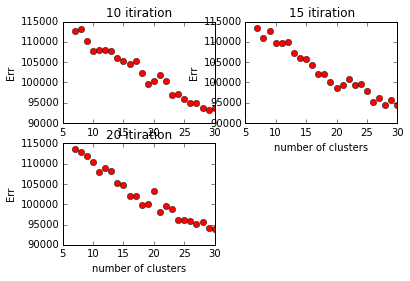

In [78]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.subplot(2, 2, 1)
plt.plot(num_cluster, err_it10, 'ro')
plt.title("10 itiration")
plt.ylabel('Err')
plt.xlabel('number of clusters')

plt.subplot(2, 2, 2)
plt.plot(num_cluster, err_it15, 'ro')
plt.title('15 itiration')
plt.ylabel('Err')
plt.xlabel('number of clusters')

plt.subplot(2, 2, 3)
plt.plot(num_cluster, err_it20, 'ro')
plt.title('20 itiration')
plt.ylabel('Err')
plt.xlabel('number of clusters')

We choose iteration time =20 because it seems to be more stable. For the number of clusters, we examine the k around elbow and decided by the distribution of number in each group. We chooae the k that enable the group number distribution less skew

K=27

In [127]:
clusters_k27 = KMeans.train(parse_data_final,27, maxIterations=20,runs=10, initializationMode="random")
prediction_k27=parse_data.map(lambda p:(p[0],p[1],clusters_k27.predict(p[1])))

In [129]:
Group_num27,Group_feature27,Group_desinger27=CalGroupInfo(prediction_k27,27)
Group_num27
#you can uncomment the line belowe to see the group info
#TellGroupInfo(Group_num27,Group_feature27,Group_desinger27)

[3,
 3,
 1,
 33,
 4,
 3,
 17,
 17,
 3,
 13,
 28,
 248,
 3,
 65,
 25,
 11,
 35,
 30,
 23,
 1,
 100,
 17,
 56,
 57,
 4071,
 323,
 4]

k=19

In [106]:
clusters_k19 = KMeans.train(parse_data_final,19, maxIterations=20,runs=10, initializationMode="random")
prediction_k19=parse_data.map(lambda p:(p[0],p[1],clusters_k19.predict(p[1])))
Group_num19,Group_feature19,Group_desinger19=CalGroupInfo(prediction_k19,19)
Group_num19
#you can uncomment the line below to see th group info
#TellGroupInfo(Group_num19,Group_feature19,Group_desinger19)

[17, 39, 42, 120, 156, 3, 261, 13, 52, 1, 53, 79, 10, 12, 4, 4, 47, 7, 4274]

k=15

In [130]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters_k15 = KMeans.train(parse_data_final,15, maxIterations=20,runs=10, initializationMode="random")
prediction_k15=parse_data.map(lambda p:(p[0],p[1],clusters_k15.predict(p[1])))
Group_num15,Group_feature15,Group_desinger15=CalGroupInfo(prediction_k15,15)
Group_num15
#you can uncomment the line below to see th group info
#TellGroupInfo(Group_num15,Group_feature15,Group_desinger15)

[10, 4265, 325, 16, 1, 18, 86, 29, 274, 35, 70, 25, 3, 24, 13]